# Visualise paleosol data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.transforms import blended_transform_factory
from matplotlib.gridspec import GridSpec
import seaborn as sns
from ternary_helper import *

# Styling
sns.set(style='ticks')
# to output editable text in svg files
rcParams['svg.fonttype'] = 'none'
# Output formats
output_fmt = ('png',)

### Import data

In [2]:
fulldata = pd.read_excel('unified_paleosols.xlsx')
fulldata.head()

,Age (Ga),Paleosol,Reference,Section,Sample,Depth (m),Relative position,CaO (wt.%),Al2O3 (wt.%),MgO (wt.%),...,K/Al (protolith),K*,CN,CNM,CIA,CIW,CIA (K*),A/(CNM+A+K*),P2O5/TiO2 (protolith),Tau P/Ti
0,2.76,Mt. Roe,"Macfarlane et al., 1994",1,90MH19,0.7,top,0.07,37.21,0.05,...,0.167306,0.061058,0.006777,0.008017,75.727738,98.176994,84.325919,0.840849,0.393103,-0.792192
1,2.76,Mt. Roe,"Macfarlane et al., 1994",1,90MH20,1.6,top,0.26,37.59,0.08,...,0.167306,0.061681,0.001936,0.003921,76.441955,99.477576,85.283619,0.848938,0.393103,-0.794139
2,2.76,Mt. Roe,"Macfarlane et al., 1994",1,103233,2.2,top,0.82,37.13,0.03,...,0.167306,0.060927,0.001936,0.002680,76.542647,99.471138,85.278887,0.851305,0.393103,-0.470935
3,2.76,Mt. Roe,"Macfarlane et al., 1994",1,90MH21,2.7,top,1.68,36.06,0.21,...,0.167306,0.059171,0.002420,0.007631,76.352244,99.320339,85.168025,0.841126,0.393103,-0.020424
4,2.76,Mt. Roe,"Macfarlane et al., 1994",1,103232,3.7,NaN,0.14,37.19,0.06,...,0.167306,0.061025,0.002420,0.003909,76.340929,99.340854,85.183110,0.848880,0.393103,-0.832353


Select wanted paleosols.

In [3]:
selected_sols = [
    'Mt. Roe',
    'Cooper Lake',
    'Kuksha',
    'Ville Marie',
    'Hokkalampi',
    'Hekpoort',
    'Drakenstein',
    'Beaverlodge',
    'Flin Flon',
    'Baraboo',
]

data = fulldata[fulldata['Paleosol'].isin(selected_sols)]

data['A/(CNM+A+K*)'].count()

556

Normalize chemical components to 100% in ternary space.

In [4]:
ternary_normalize(data, 'CNM', 'Al (mol)', 'K*', suffix='_cnm-k*')
data.iloc[:, -3:].describe()

,CNM_cnm-k*,Al (mol)_cnm-k*,K*_cnm-k*
count,556.000000,556.000000,556.000000
mean,24.188293,68.540899,7.270808
std,18.823346,17.089329,6.329537
min,0.000000,28.709100,0.000000
25%,5.857065,53.497502,2.264440
50%,20.893741,69.667880,4.967175
75%,41.538011,84.530846,11.022204
max,71.034240,96.419645,25.048534


## Figure 1 -- Estimated kaolinicity in paleosols

Cull unneeded datapoints.

In [5]:
culldata = data[data["Relative position"] != 'proto']
culldata = culldata[culldata["Relative position"] != 'sill']
culldata = culldata[culldata["Relative position"] != 'cover']

culldata['A/(CNM+A+K*)'].count()

495

Cut into time bins.

In [6]:
culldata['Bin'] = pd.cut(
    x=culldata['Age (Ga)'],
    bins=[1.5, 2.0, 2.4, 3.0],
    labels=['<2.0 Ga', '2.4-2.0 Ga', '>2.4 Ga'],
)
culldata["Bin"].cat.reorder_categories(['>2.4 Ga', '2.4-2.0 Ga', '<2.0 Ga'], ordered=True, inplace=True)

culldata.groupby(by='Bin')['A/(CNM+A+K*)'].count()

Bin
>2.4 Ga       161
2.4-2.0 Ga    227
<2.0 Ga       107
Name: A/(CNM+A+K*), dtype: int64

Impose a category order.

In [7]:
culldata['Paleosol'] = pd.Categorical(
    culldata['Paleosol'], categories=selected_sols, ordered=True,
)
culldata.sort_values('Paleosol', inplace=True)

# Create nice labels
culldata['paleoname'] = "~" + culldata['Age (Ga)'].astype(str) + " Ga " + culldata['Paleosol'].astype(str)

Draw boxplots.

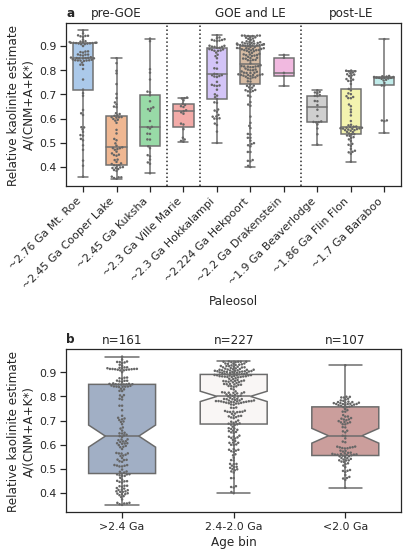

In [8]:
f1 = plt.figure(figsize=(6, 9))
g1 = GridSpec(nrows=2, ncols=4, figure=f1, hspace=1)
ax1 = f1.add_subplot(g1[0, :])
ax2 = f1.add_subplot(g1[1, :])

sns.boxplot(
    data=culldata,
    ax=ax2,
    x='Bin',
    y='A/(CNM+A+K*)',
    width=0.6,
    palette='vlag',
    whis=[0, 100],
    notch=True,
)

sns.swarmplot(
    data=culldata,
    ax=ax2,
    x='Bin',
    y='A/(CNM+A+K*)',
    color=".4",
    size=2.5,
)

for i, u in enumerate(culldata['Bin'].unique()):
    ax2.text(
        x=i, y=1.02, ha='center',
        s="n={}".format(culldata[culldata['Bin'] == u]['A/(CNM+A+K*)'].count()),
    )

ax2.set_xlabel("Age bin")
ax2.set_ylabel("Relative kaolinite estimate\nA/(CNM+A+K*)")

# Panel 2 ------------------------------------------------------------------------

# Data
sns.boxplot(
    data=culldata, ax=ax1, x='paleoname', y='A/(CNM+A+K*)',
    width=0.6, palette='pastel', whis=[0, 100],
)
sns.swarmplot(
    data=culldata, ax=ax1, x='paleoname', y='A/(CNM+A+K*)',
    color=".4", size=2.5,
)

# Labels
ax1.set_xticklabels(
    ax1.get_xticklabels(), rotation=45, fontdict=dict(ha='right'),
)
ax1.set_ylabel("Relative kaolinite estimate\nA/(CNM+A+K*)")
ax1.set_xlabel("Paleosol")

# Divide by age
for x in (2.5, 3.5, 6.5):
    ax1.axvline(x=x, ls='dotted', color=sns.axes_style()['axes.edgecolor'])
for x, s in zip((1, 5, 8), ('pre-GOE', 'GOE and LE', 'post-LE')):
    ax1.text(
        x=x, y=1.02, s=s, ha='center', va='bottom',
        transform=blended_transform_factory(ax1.transData, ax1.transAxes)
    )
    
# Figure labels
for ax, s in zip((ax1, ax2), ('a', 'b')):
    ax.text(
        transform=ax.transAxes, x=0, y=1.02, s=s,
        fontdict=dict(weight='bold'), ha='left', va='bottom',
    )

f1.align_ylabels()

In [9]:
for ext in output_fmt:
    f1.savefig(f'figures/Figure 1.{ext}', bbox_inches='tight',  dpi=350)

## Figure S4

### Import mineral references

In [10]:
mindata = pd.read_excel('input_data/mineral_references.xlsx', index_col=0)
ternary_normalize(mindata, 'CNM', 'Al (mol)', 'K (mol)', suffix='_cnm')
ternary_normalize(mindata, 'CN', 'Al (mol)', 'K (mol)', suffix='_cn')
for c in mindata.columns:
    if '_cnm' in c or '_cn' in c:
        mindata[f'{c}-k*'] = mindata[c]
mindata.rename({'K (mol)_cnm-k*': 'K*_cnm-k*'}, axis='columns', inplace=True)

# REMOVE this if you want to add them back in
mindata.drop(labels=['Illite', 'Phlogopite'], axis='index', inplace=True)

mindata.iloc[:, -13:]

,CNM,CNM_cnm,Al (mol)_cnm,K (mol)_cnm,CN_cn,Al (mol)_cn,K (mol)_cn,CNM_cnm-k*,Al (mol)_cnm-k*,K*_cnm-k*,CN_cn-k*,Al (mol)_cn-k*,K (mol)_cn-k*
mineral,,,,,,,,,,,,,
Orthoclase,0.000000,0.000000,49.945474,50.054526,0.000000,49.945474,50.054526,0.000000,49.945474,50.054526,0.000000,49.945474,50.054526
Montmorillonite,0.036414,16.667561,83.332439,0.000000,16.667561,83.332439,0.000000,16.667561,83.332439,0.000000,16.667561,83.332439,0.000000
Kaolinite,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,0.000000
Clinochlore,0.651026,79.493531,20.506469,0.000000,0.000000,100.000000,0.000000,79.493531,20.506469,0.000000,0.000000,100.000000,0.000000
Plagioclase,0.276994,60.007140,39.992860,0.000000,60.007140,39.992860,0.000000,60.007140,39.992860,0.000000,60.007140,39.992860,0.000000
Gibbsite,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,0.000000
Muscovite,0.000000,0.000000,74.958320,25.041680,0.000000,74.958320,25.041680,0.000000,74.958320,25.041680,0.000000,74.958320,25.041680


### Plot data on ternary axes

In [11]:
# more specific functions for the paleosol project

def tern_ages(df, age_divisions, axeslist, include_ends=True,
              scattercols=['K*_cnm-k*', 'Al (mol)_cnm-k*', 'CNM_cnm-k*'], agecol='Age (Ga)',
              solcol='Paleosol', legend=True, fancylabel=True, title=True, unit=' Ga',
              **kwargs):
    """
    Divide the *df* DataFrame by numbers given in *age_divisions*, corresponding
    to values in *agecol*, then for each division, paint values in *df[scattercols]*
    onto axes listed in *axeslist*, colouring the data by the column *solcol*.
    
    If *legend=True*, print a legend for every ternary ax, smartly handling the position.
    If *fancylabel=True*, concatenate the value of *agecol*, *solcol* and *unit* for the
    legend labels. If *title=True*, draw a title on the top left corner.
    
    kwargs passed to scatter_tern_color().
    """
    # make a new column for fancier legend handles:
    if fancylabel:
        df = df.copy()
        df['orig_sol'] = df[solcol]
        df[solcol] = df['orig_sol'] + ', ' + df[agecol].map('{:,.2f}'.format) + unit
    
    # cut data and scatter
    # TODO: use pd.cut() instead!
    agesdict = cut_dataframe(df, column=agecol, divisions=age_divisions,
                             include_ends=include_ends, append=unit)
    for tax, (name, subdf) in zip(axeslist, agesdict.items()):
        scatter_tern_color(tax, subdf, scattercols[0], scattercols[1], scattercols[2],
                           colorcol=solcol, **kwargs)
        
        # handle legend; if too big, shift the position outside the axes
        if legend:
            if len(subdf[solcol].unique()) > 6:
                loc = 'upper left'
                bbox_to_anchor = (0.7, 1)
            else:
                loc = 'lower center'
                bbox_to_anchor = None
            tax.legend(fontsize='small', loc=loc, framealpha=1, handlelength=1,
                       handletextpad=0.5, bbox_to_anchor=bbox_to_anchor)
        if title:
            tax.set_title(name, fontsize='x-large', loc='left')
    

def draw_minerals(tax, mindf, scattercols=['K*_cnm-k*', 'Al (mol)_cnm-k*', 'CNM_cnm-k*'],
                  annotate=True, edgecolor='black', color='black', marker='D', s=30,
                  labelattrs={'Kaolinite':       {'s': 'Kaolinite', 'xy': (47, 85),
                                                  'ha':'right', 'fontsize': 'small'},
                              'Montmorillonite': {'s': 'Smectite', 'xy': (39, 71),
                                                  'ha': 'right', 'fontsize': 'small'},
                              'Orthoclase':      {'s': 'K-feldspar', 'xy': (72, 42),
                                                  'ha': 'right', 'fontsize': 'small'},
                              'Plagioclase':     {'s': 'Plagioclase', 'xy': (20, 38),
                                                  'ha': 'right',  'fontsize': 'small'},
                              'Clinochlore':     {'s': 'Chlorite', 'xy': (26, 16),
                                                  'ha': 'right',  'fontsize': 'small'},
                              'Illite':          {'s': 'Illite', 'xy': (50, 42),
                                                  'xytext': (53, 33),
                                                  'arrowprops': {'arrowstyle': '->'},
                                                  'ha': 'center', 'fontsize': 'small'},
                              'Muscovite':       {'s': 'Muscovite', 'xy': (61 , 68),
                                                  'ha': 'left', 'fontsize': 'small'}},
                  **kwargs):
    """
    Plot mineral data and labels on a ternary ax *tax*.
    """
    for i, mineral in mindata.iterrows():
        tax.scatter([mineral[scattercols].values], edgecolor=edgecolor, color=color,
                    s=s, marker=marker, zorder=3, **kwargs)
    # annotate minerals
    if annotate:
        for mineral in mindf.index:
            if mineral in labelattrs:
                tax.get_axes().annotate(**labelattrs[mineral])

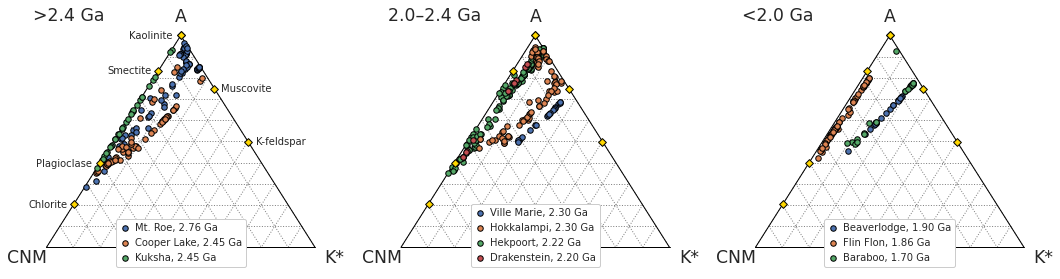

In [12]:
# draw fig
sel_small_fig, sel_small_axes = draw_ternfig(ncols=3, labels='cnm-k*', figsize=(18, 4.5))

tern_ages(data, age_divisions=(2.4, 2.0), axeslist=list(reversed(sel_small_axes)),
          scattercols=['K*_cnm-k*', 'Al (mol)_cnm-k*', 'CNM_cnm-k*'], s=30,
          edgecolor='black', bring_forward='Hokkalampi, 2.30 Ga')
for ax, label in zip(sel_small_axes, (True, False, False)):
    draw_minerals(ax, mindata, scattercols=['K (mol)_cnm', 'Al (mol)_cnm', 'CNM_cnm'],
                  color='gold', annotate=label,
                  labelattrs={'Kaolinite':       {'text': 'Kaolinite', 'xy': (47, 85),
                                                  'ha': 'right', 'fontsize': 'small'},
                              'Montmorillonite': {'text': 'Smectite', 'xy': (39, 71),
                                                  'ha': 'right', 'fontsize': 'small'},
                              'Orthoclase':      {'text': 'K-feldspar', 'xy': (78, 42),
                                                  'ha': 'left', 'fontsize': 'small'},
                              'Plagioclase':     {'text': 'Plagioclase', 'xy': (17, 33),
                                                  'ha': 'right',  'fontsize': 'small'},
                              'Clinochlore':     {'text': 'Chlorite', 'xy': (8, 16),
                                                  'ha': 'right',  'fontsize': 'small'},
                              'Illite':          {'text': 'Illite', 'xy': (50, 42),
                                                  'xytext': (53, 33),
                                                  'arrowprops': {'arrowstyle': '->'},
                                                  'ha': 'center', 'fontsize': 'small'},
                              'Muscovite':       {'text': 'Muscovite', 'xy': (65 , 63.5),
                                                  'ha': 'left', 'fontsize': 'small'}})
    
sel_small_fig.patch.set_facecolor('white')

In [13]:
for ext in output_fmt:
    sel_small_fig.savefig(f'figures/Figure S4.{ext}', bbox_inches='tight', dpi=350)

## Figure S5 -- P leaching in paleosols

(-1.2, 1.5)

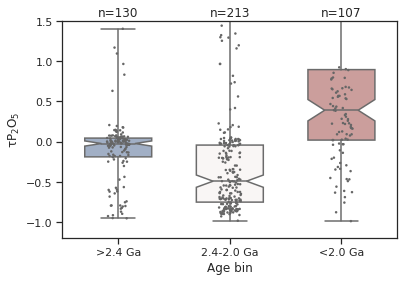

In [14]:
f2, ax21 = plt.subplots()

sns.boxplot(
    data=culldata, ax=ax21, x='Bin', y='Tau P/Ti',
    width=0.6, palette='vlag', whis=[0, 100], notch=True,
)

sns.stripplot(
    data=culldata, ax=ax21, x='Bin', y='Tau P/Ti',
    color=".4", size=2.5,
)

for i, u in enumerate(culldata['Bin'].unique()):
    ax21.text(
        x=i, y=1.02, ha='center', transform=blended_transform_factory(ax21.transData, ax21.transAxes),
        s="n={}".format(culldata[culldata['Bin'] == u]['Tau P/Ti'].count()),
    )

ax21.set_xlabel("Age bin")
ax21.set_ylabel("τP$_2$O$_5$")

ax21.set_ylim(top=1.5, bottom=-1.2)

In [15]:
for ext in output_fmt:
    f2.savefig(f'figures/Figure S5.{ext}', bbox_inches='tight', dpi=350)